# This script analyze the NHDP results of EGAS00001004809 

Cells from the EGAS00001004809 dataset were analyzed using the NHDP algorithm. The results are stored in the following files:


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scanpy as sc
import anndata as ad
import rpy2.robjects as robjects
import sys as sys
sys.path.append('/home/xinghua/projects/PanCancer_scRNA_analysis/utils/')
from scRNA_utils import *

## Read in the NHDP and AnnData results for cell type

### Identify the model with the highest likelihood for each cell type
We have performed NHDP analysis for each cell type for 6 times. The results are stored in the following files:
"/data/ICI_exprs/ICI_NHDP/EGAS00001004809_high_variance_gene_NHDP/NHDP_runs/"
The following script will identify the model with the highest likelihood for each cell type.



In [2]:
RData_dir = "/data/ICI_exprs/ICI_NHDP/EGAS00001004809_high_variance_gene_NHDP/NHDP_runs/"
cell_types = ['B', 'T', 'M', 'Epi', 'Endo', 'Fibro']
# use a dictionary to store the best model for each cell type.  Key is cell type, value is the best model
best_models = {}
high_likelihood = {}

#list all RData files
files = os.listdir(RData_dir)
files = [f for f in files if f.endswith('.RData')]
for f in files:
    #print ("Processing file: ", f)
    # read in the RData file
    robjects.r['load'](RData_dir + f)
    # extract the 'tree' object
    nHDP_trained_mb = robjects.r['nHDP_trained_mb']
    f_likelihood = max(np.array(nHDP_trained_mb.rx('likelihood')[0])) #[0]

     #detect the cell type 
    f_cell_type = f.split('_')[3]
    if f_cell_type not in high_likelihood.keys():
        high_likelihood[f_cell_type] = f_likelihood
        best_models[f_cell_type] = f
    else:
        if f_likelihood > high_likelihood[f_cell_type]:
            high_likelihood[f_cell_type] = f_likelihood
            best_models[f_cell_type] = f

# iterate through the best models for each cell type, and print the model name and the likelihood
for k, v in best_models.items():
    print ("Cell type: ", k, " best model: ", v, " likelihood: ", high_likelihood[k])


Cell type:  T  best model:  1863-counts_cells_cohort1_T_cells.h5ad.NHDP-2.RData  likelihood:  -99996535.3565013
Cell type:  Epi  best model:  1863-counts_cells_cohort1_Epi_cells.h5ad.NHDP-3.RData  likelihood:  -58428311.0732158
Cell type:  Fibro  best model:  1863-counts_cells_cohort1_Fibro_cells.h5ad.NHDP.RData  likelihood:  -72061953.69629507
Cell type:  Endo  best model:  1863-counts_cells_cohort1_Endo_cells.h5ad.NHDP-1.RData  likelihood:  -20474254.148915857
Cell type:  M  best model:  1863-counts_cells_cohort1_M_cells.h5ad.NHDP-4.RData  likelihood:  -30034927.2568338
Cell type:  B  best model:  1863-counts_cells_cohort1_B_cells.h5ad.NHDP.RData  likelihood:  -11601523.540345445


### Read in h5ad files with metadata

In [3]:
h5ad_dir = "/data/ICI_exprs/ICI_NHDP/EGAS00001004809_high_variance_gene_NHDP/"
files = os.listdir(h5ad_dir)
h5ad_files = [f for f in files if f.endswith('.h5ad')]
adata_dict = {} 
for f in h5ad_files:
    # parse the cell type from the file name
    f_cell_type = f.split('_')[3]
    adata_dict[f_cell_type] = sc.read_h5ad(h5ad_dir+f)

## Processing T cell data

In [20]:
T_NHDP = parseNHDP_RData(RData_dir + best_models['T'])
T_NHDP

/home/xinghua/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinghua/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


{'cell_by_GEM': AnnData object with n_obs × n_vars = 55805 × 85,
 'GEM_by_gene': AnnData object with n_obs × n_vars = 4936 × 85}

In [6]:
T_NHDP = parseNHDP_RData(RData_dir + best_models['T'])
adata_T = T_NHDP['cell_by_GEM']

# Copy annotation from the original AnnData object
adata_T.obs = adata_dict['T'].obs
adata_T.obsm = adata_dict['T'].obsm
adata_T.uns = adata_dict['T'].uns
adata_T.raw = adata_T

/home/xinghua/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinghua/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(array([10.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  2.,  5.,  2.,  3.,
         2.,  1.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,  6.,  4.,  6.,  5.,
         2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  6.,  2.,
         3.,  3.,  2.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  2.]),
 array([ 0.        ,  0.29648186,  0.59296372,  0.88944557,  1.18592743,
         1.48240929,  1.77889115,  2.07537301,  2.37185486,  2.66833672,
         2.96481858,  3.26130044,  3.5577823 ,  3.85426415,  4.15074601,
         4.44722787,  4.74370973,  5.04019159,  5.33667344,  5.6331553 ,
         5.92963716,  6.22611902,  6.52260088,  6.81908273,  7.11556459,
         7.41204645,  7.70852831,  8.00501017,  8.30149202,  8.59797388,
         8.89445574,  9.1909376 ,  9.48741946,  9.78390131, 10.08038317,
        10.37686503, 10.67334689, 10.96982875, 11.2663106 , 11.56279246,
        11.85927432, 12.15575618, 12.45223804, 12.74871989, 13.04520175,
        13.34168361, 13.63816547, 13.93464733, 14.23112918,

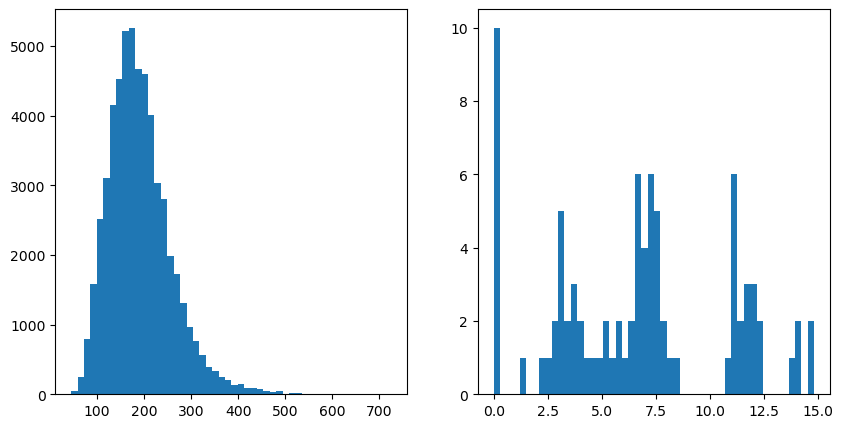

In [8]:
# plot two histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2,1)
plt.hist(np.sum(adata_T.X, axis= 1), bins=50)
plt.subplot(1, 2,2)
plt.hist(np.log(np.sum(adata_T.X, axis= 0)+1), bins=50)

In [18]:
### filter GEMs with colsum < 100
nonZeroGEMs = adata_T.var_names[(np.sum(adata_T.X, axis= 0) > 1000) & (np.sum(adata_T.X > 2, axis= 0) > 500)]
print(nonZeroGEMs)


Index(['0', '1', '2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object')


## Plot GEMs

/home/xinghua/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/xinghua/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/xinghua/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


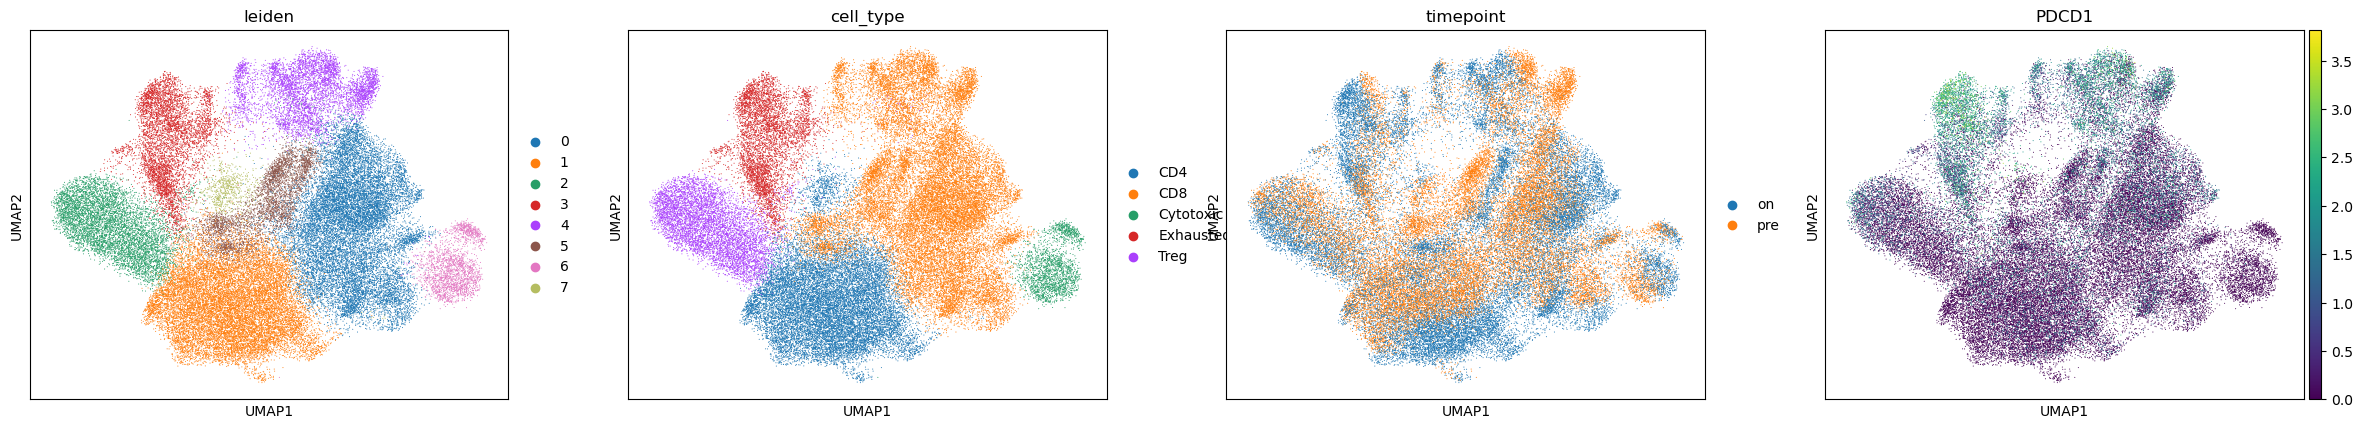

In [19]:
adata_T_h5ad = adata_dict['T']
sc.pl.umap(adata_T_h5ad, color = ['leiden', 'cell_type', 'timepoint', 'PDCD1'])

In [20]:
# make mono-color colormap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def create_custom_blue_colormap():
    # Define the colors and positions for the custom colormap
    colors = [(0.0, 'white'), (0.5, 'lightblue'), (1.0, 'blue')]  # Blue shades from white to blue
    cmap_name = 'custom_blue_colormap'
    
    # Create the colormap
    cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

    return cmap

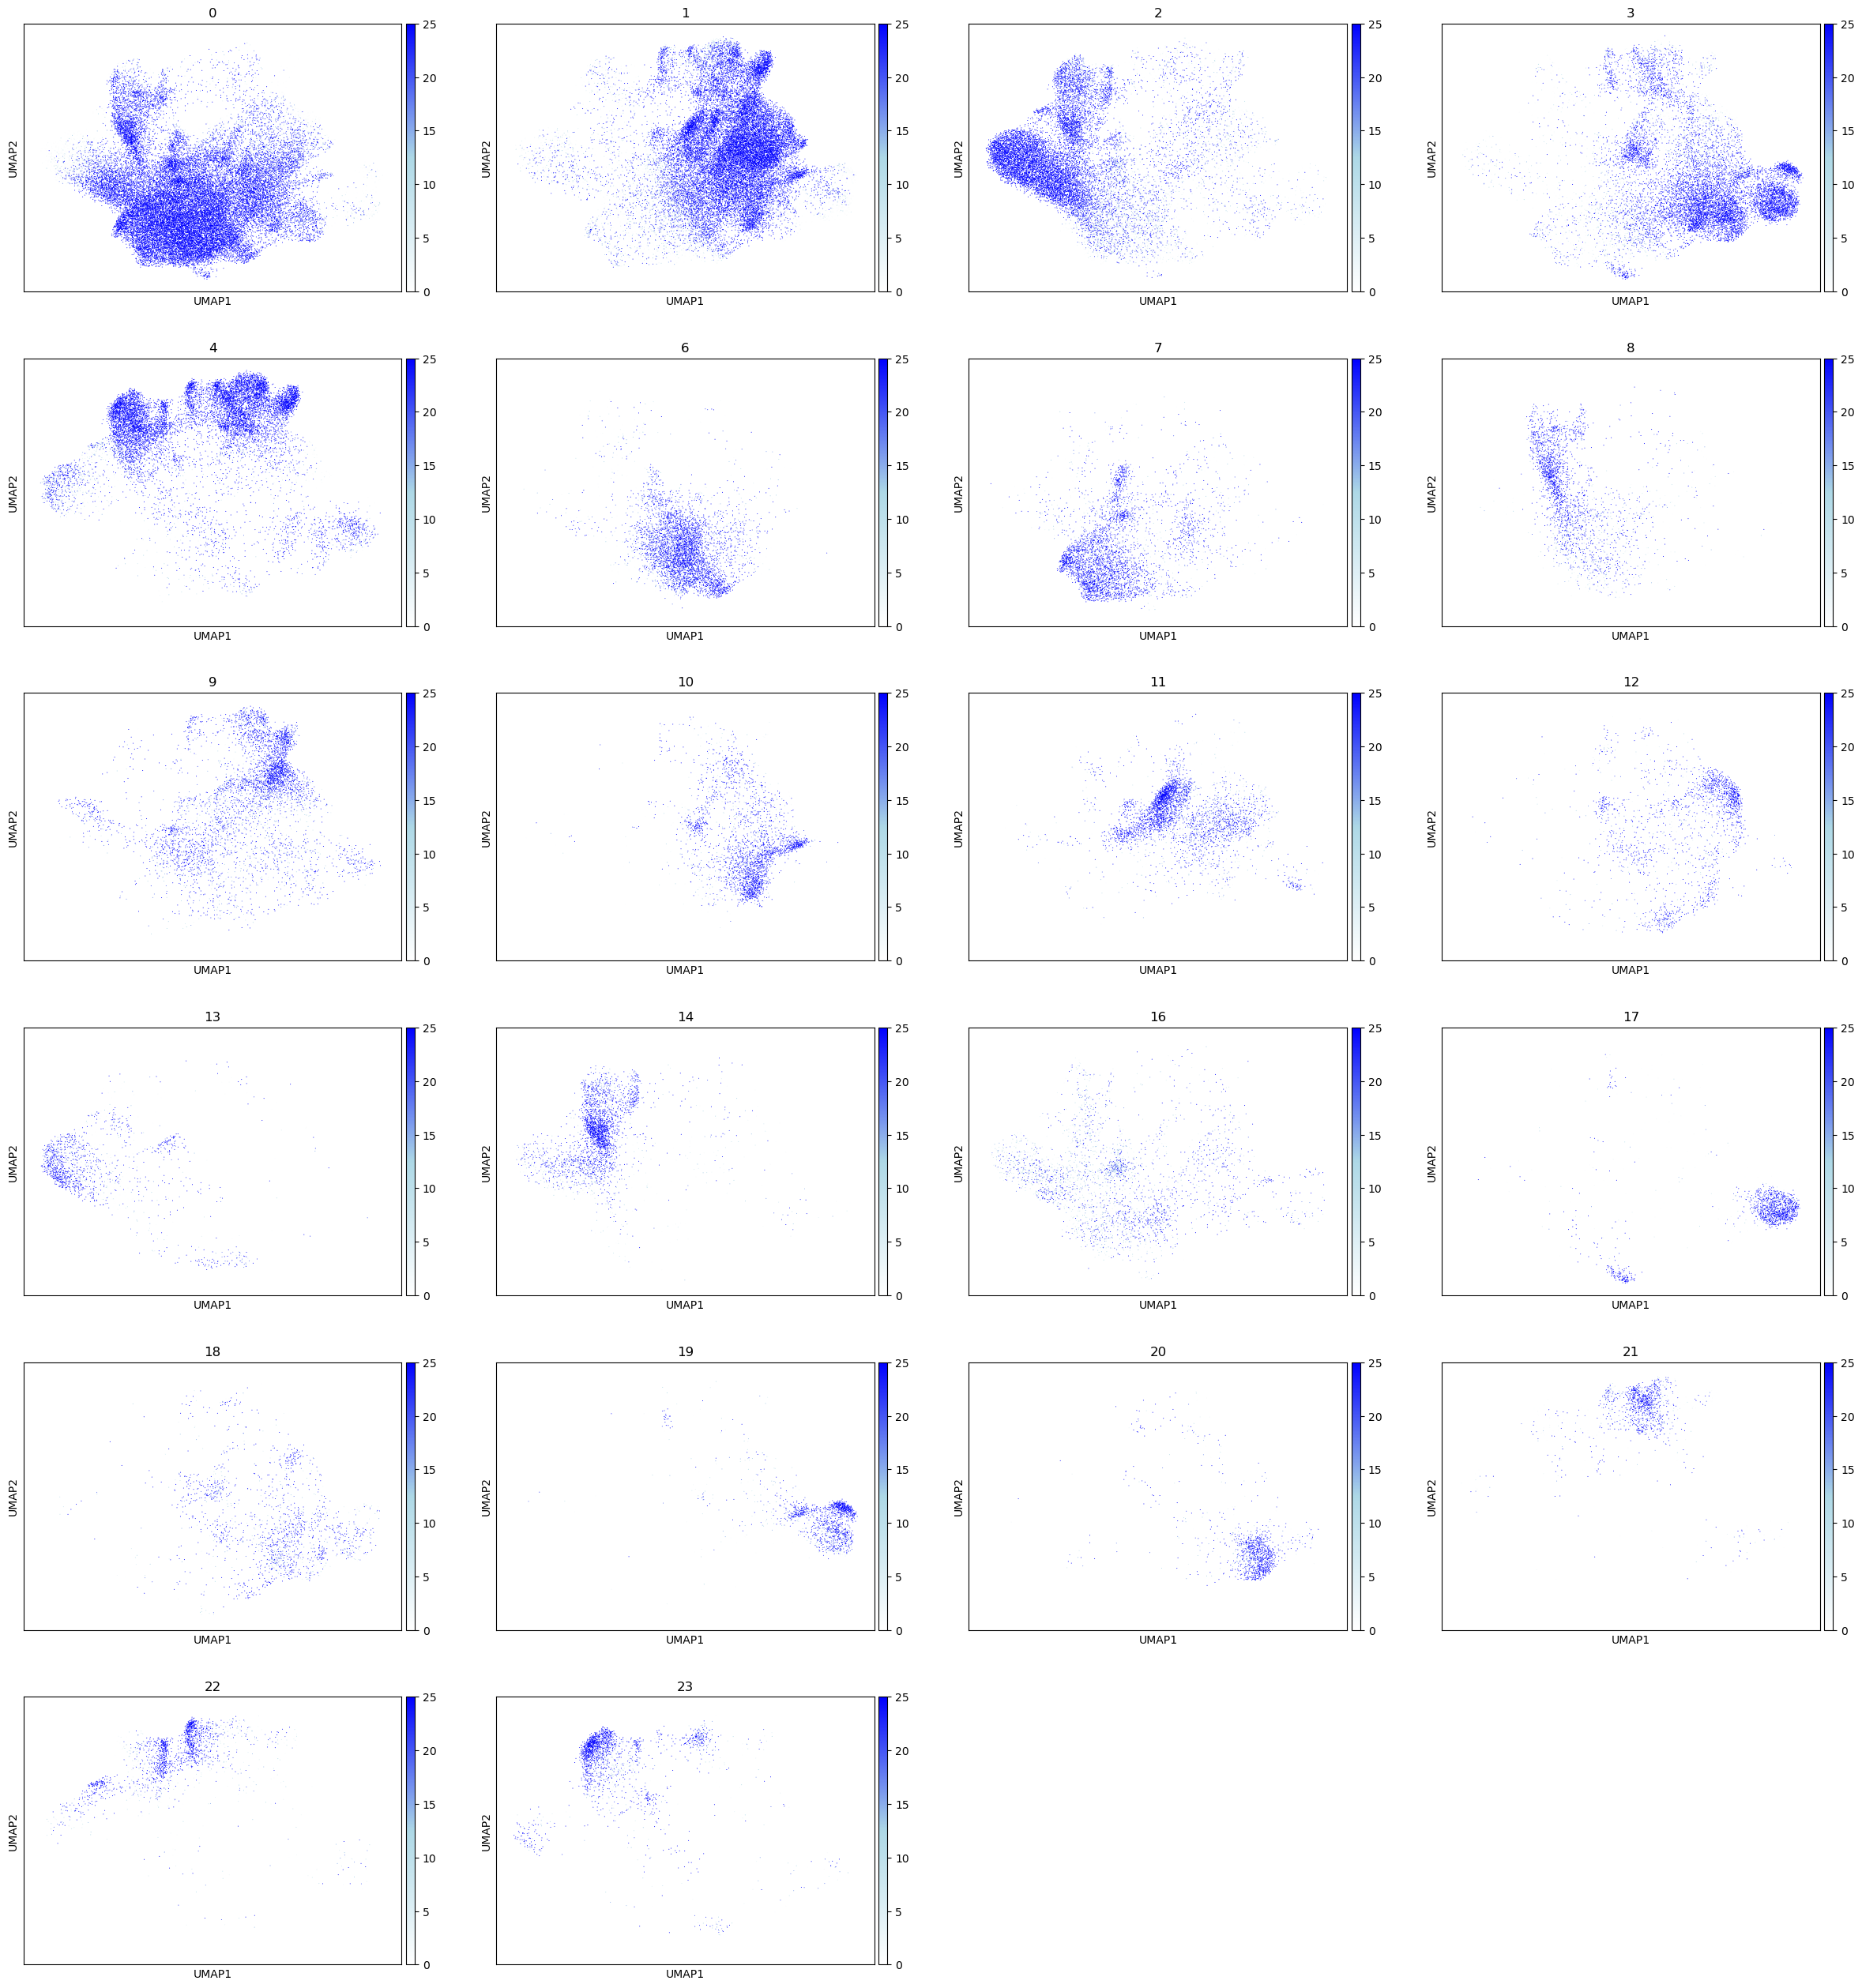

In [21]:
blue_cmap = create_custom_blue_colormap()
sc.pl.umap(adata_T, color = nonZeroGEMs, use_raw = False, cmap=blue_cmap, ncols = 4, vmax=25)



## Transform to psuedo-bulk data and find differentially expressed GEMs



In [22]:
# perform pseudotime analysis
adata_pseudobulk = scRNA2PseudoBulkAnnData(adata_T, sample_id_col='sample_id')
adata_pseudobulk

/home/xinghua/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 62 × 85
    obs: 'patient_id', 'sample_id', 'timepoint', 'treatment', 'n_genes', 'n_counts', 'leiden', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    uns: 'pseudoBulk'

## Plot GEMs expressed in each cell type and compare 'pre' and 'on' treatment

In [45]:
def plotGEMs(adata, cluster_id_col, cluster_id_to_plot, ncols=4):
    '''
    Plot the expression of genes in a cluster
    Parameters:
        adata: AnnData object
        cluster_id_col: column name in adata.obs that contains the cluster id
        cluster_id_to_plot: cluster id to plot
        ncols: number of columns in the plot
    '''

    # check input values
    if cluster_id_col not in adata.obs.columns:
        print("Error: cluster_id_col not found in adata.obs.columns")
        return
    elif not cluster_id_col:
        print("Error: cluster_id_col is empty")
        return
    
    # check if cluster_id_to_plot is in adata.obs[cluster_id_col]
    if cluster_id_to_plot not in adata.obs[cluster_id_col].unique():
        print("Error: cluster_id_to_plot not found in adata.obs[cluster_id_col]")
        return
    
    # identify the cells assigned in the cluster_id_to_plot
    adata_tmp = adata[adata.obs[cluster_id_col] == cluster_id_to_plot, :].copy()  
    nCells, nGenes = adata_tmp.shape
    # search for GEMs expressed in the cells of this cluster
    GEMs_exprs_in_cls = adata_tmp.var_names[(np.sum(adata_tmp.X > 50, axis= 0) / nCells > .05)].tolist()
    GEMs_exprs_in_cls = ['timepoint'] + GEMs_exprs_in_cls
    sc.pl.umap(adata_tmp, color = GEMs_exprs_in_cls)

/home/xinghua/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


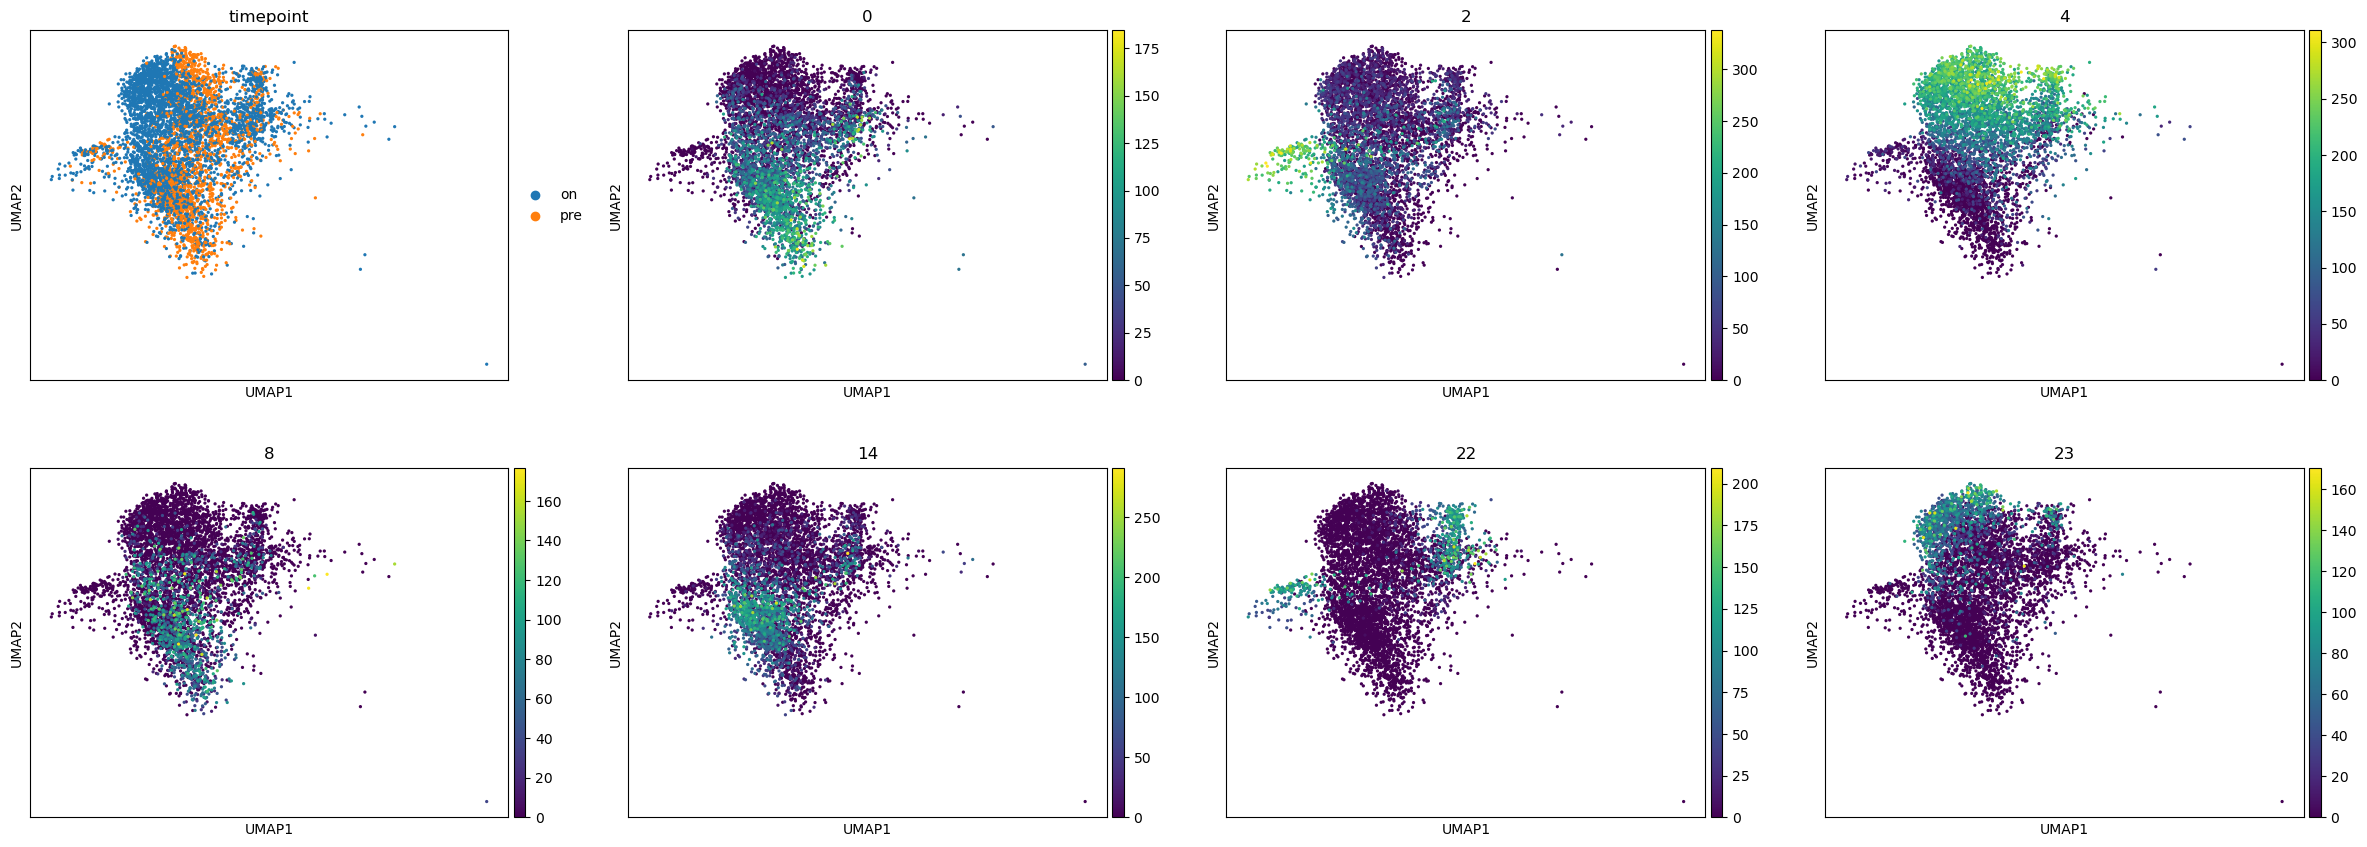

In [44]:
# find cells belong to cluster 3
adata_tmp = adata_T[adata_T.obs['leiden']=='3',:].copy()
nCells, nGenes = adata_tmp.shape
# search for genes expressed in the cells of this cluster
# GEMs_exprs_in_cls = [i for i in range(nGenes) if np.sum(adata_tmp.X[:,i]) > 0]
GEMs_exprs_in_cls = adata_T.var_names[(np.sum(adata_tmp.X > 25, axis= 0) / nCells > .05)].tolist()
GEMs_exprs_in_cls = ['timepoint'] + GEMs_exprs_in_cls
sc.pl.umap(adata_tmp, color = GEMs_exprs_in_cls)

In [18]:

adata_GEM = results['1863-counts_cells_cohort1_T_cells.h5ad.NHDP.RData' ]['GEM_by_gene']
print('Gem-by-gene matrix:', adata_GEM.shape)

# sort adata_T to find the top 10 genes for each column
for i in range(adata_GEM.shape[1]):
    # find the top 10 genes for each column
    top_50 = adata_GEM.obs.index[np.argsort(adata_GEM.X[:,i])[-50:]].tolist()
    print(i, ":", top_50)
    

Gem-by-gene matrix: (4936, 85)
0 : ['TPI1', 'AHNAK', 'PKM', 'SLC2A3', 'JUN', 'IL2RG', 'CD7', 'ISG20', 'ANXA1', 'LY6E', 'DNAJB1', 'LDHA', 'TNFAIP3', 'HMGN2', 'TAGLN2', 'TRBC2', 'GIMAP7', 'DDIT4', 'SPOCK2', 'KLF6', 'ZFP36L1', 'NFKBIA', 'IFITM2', 'ZFP36', 'S100A11', 'FOS', 'CD69', 'S100A10', 'CXCR4', 'DUSP1', 'SRGN', 'CD74', 'S100A4', 'TXNIP', 'TSC22D3', 'JUNB', 'IL32', 'LTB', 'VIM', 'IL7R', 'IFITM1', 'GAPDH', 'FTL', 'ZFP36L2', 'PFN1', 'FTH1', 'HLA-A', 'TMSB10', 'TPT1', 'ACTB']
1 : ['CLEC2B', 'APOBEC3G', 'LDHA', 'ITM2C', 'COTL1', 'HMGN2', 'GZMM', 'ISG20', 'DUSP1', 'RNF213', 'TRBC2', 'GIMAP7', 'HLA-DRB1', 'S100A10', 'TSC22D3', 'DUSP2', 'IFITM2', 'HLA-DPA1', 'CD69', 'S100A4', 'KLF6', 'LY6E', 'HLA-DPB1', 'CD8B', 'TXNIP', 'CTSW', 'JUNB', 'CXCR4', 'ZFP36', 'CD8A', 'CCL4', 'SRGN', 'ZFP36L2', 'IFITM1', 'FTL', 'VIM', 'GAPDH', 'IL32', 'CD74', 'FTH1', 'TPT1', 'PFN1', 'GZMK', 'NKG7', 'TMSB10', 'CST7', 'HLA-A', 'ACTB', 'GZMA', 'CCL5']
2 : ['PIM2', 'TNFAIP3', 'DNPH1', 'ZFP36L2', 'TAGLN2', 'LDHA', 'RNF

In [19]:
x = np.array([1,2,5,3,10,4]) 

In [20]:
np.argsort(x)

array([0, 1, 3, 5, 2, 4])

In [21]:
x[np.argsort(x)[-3:]]

array([ 4,  5, 10])